## Severity - modelling summary

Here I picked on the key modelling results

In [1]:
from groo.groo import get_root
root_dir = get_root(".root_dir_covid")
import os
os.chdir(root_dir)
import sys
sys.path.append(os.path.join(root_dir, "covid-fear", "scripts"))

import numpy as np
import pandas as pd
from cov_functions import *
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import bambi as bmb
import arviz as az
import json
import pickle
import bammm.bammm as mm
import patsy
from IPython import display

WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


### Covid-related variables being predicted (reminder)

In [2]:

df = pd.read_csv(os.path.join(root_dir, 'output', 'questionnaires', 'covid_factors_overview.csv')).filter(regex='^ML', axis=1)
df=df.rename(columns={"ML1":"F3_Economic_Impact_Worry", "ML2":"F5_Worry", "ML3":"F1_Close_Person_Worry", "ML4":"F4_Prob_Estimates", 
                                       "ML5":"F2_Anxiety_Avoidance", "ML6":"F6_Skepticism"})
for i in df.columns:
    df[i]  = df[i].astype(str).str.replace('nan', '')
    
df

F2_Anxiety_Avoidance                    F5_Worry  \
0           q7_anx_another_beh           q7_beh_wash_hands   
1       q7_anx_eating_food_out        q7_diff_beh_freq_num   
2         q7_anx_public_transp        q7_diff_beh_freq_num   
3    q7_anx_stand_close_to_ppl  q7_inf_worry_frequency_num   
4         q7_anx_touching_surf  q7_inf_worry_frequency_num   
5             q7_anx_visit_doc           q7_initial_scared   
6             q7_beh_avoid_ppl             q7_vir_made_lab   
7   q7_beh_avoid_public_places                q7_worry_die   
8                                        q7_worry_infected   
9                                      q7_worry_insuf_help   
10                                       q7_worry_shortage   
11                                       q7_worry_sthg_bad   
12                                          q8_prob_die_me   

           F4_Prob_Estimates F1_Close_Person_Worry F3_Economic_Impact_Worry  \
0        q7_initial_surprise     q6_media_freq_num     q7_worry_econ_impact   
1         q8_prob_die_closep         q7_closep_die      q8_prob_econ_imp_me   
2           q8_prob_inf_avgp   q7_worry_closep_inf                            
3         q8_prob_inf_closep                                                  
4             q8_prob_inf_me                                                  
5   q8_t_econ_back_norm_days                                                  
6   q8_t_life_back_norm_days                                                  
7         q8_t_pand_end_days                                                  
8                                                                             
9                                                                             
10                                                                            
11                                                                            
12                                                                            

              F6_Skepticism  
0       q7_people_overreact  
1   q7_vir_not_as_dangerous  
2    q8_t_secondw_when_days  
3                            
4                            
5                            
6                            
7                            
8                            
9                            
10                           
11                           
12

### Trait variables (predictors) 

In [3]:
trait_factor_names = ["TF1_Self_Consciousness", "TF2_Positive", "TF3_Catastrophizing",  "TF4_Physiological_Anx",  "TF5_Depression",  "TF6_Cognitive_Anx"]
raw_trait_factor_names = ["ML"+str(i) for i in range(1,7)]

trait_factor_dict = dict(zip(raw_trait_factor_names, trait_factor_names))

df = pd.read_csv(os.path.join(root_dir, 'output', 'questionnaires', 'trait_factors_overview.csv')).filter(regex='^ML', axis=1)

df=df.rename(columns=trait_factor_dict)
for i in df.columns:
    df[i]  = df[i].astype(str).str.replace('nan', '')
    
df

TF3_Catastrophizing  \
0                              bdi_sex_drive   
1                                  bdi_worry   
2                        cat_bad_month_fired   
3             cat_disaster_will_happen_to_me   
4                          cat_house_burgled   
5   cat_i_am_going_through_worse_than_others   
6                   cat_imagine_health_issue   
7                     cat_major_env_disaster   
8                  cat_make_big_mistake_soon   
9            cat_partner_late_means_accident   
10          cat_problems_get_worse_over_time   
11                 cat_symptom_think_serious   
12                  cat_think_about_unlikely   
13         cat_think_will_lose_someone_close   
14                   cat_treatment_wont_work   
15                 cat_war_in_next_few_years   
16       cat_will_always_have_money_problems   
17                   cat_worst_cases_happens   
18    sticsa_trait_picture_future_misfortune   
19      sticsa_trait_think_worst_will_happen   

                                TF4_Physiological_Anx  \
0                    stai_trait_feel_nervous_restless   
1                      sticsa_trait_avoiding_thoughts   
2             sticsa_trait_breathing_fast_and_shallow   
3                    sticsa_trait_butterflies_stomach   
4   sticsa_trait_cannot_concentrate_over_intrusive_th   
5                         sticsa_trait_face_feels_hot   
6            sticsa_trait_feel_agonized_over_problems   
7                             sticsa_trait_feel_dizzy   
8                     sticsa_trait_feel_trembly_shaky   
9                       sticsa_trait_heart_beats_fast   
10                 sticsa_trait_legs_hands_feel_stiff   
11                         sticsa_trait_muscles_tense   
12                          sticsa_trait_muscles_weak   
13                          sticsa_trait_palms_clammy   
14                   sticsa_trait_repetitive_thoughts   
15                            sticsa_trait_throat_dry   
16                   sticsa_trait_trouble_remembering   
17         sticsa_trait_worry_cannot_control_thoughts   
18                                                      
19                                                      

                         TF2_Positive  \
0                          bdi_future   
1   stai_trait_am_calm_cool_collected   
2               stai_trait_am_content   
3                 stai_trait_am_happy   
4         stai_trait_am_steady_person   
5            stai_trait_feel_pleasant   
6              stai_trait_feel_rested   
7           stai_trait_feel_satisfied   
8              stai_trait_feel_secure   
9     stai_trait_wish_happy_as_others   
10                                      
11                                      
12                                      
13                                      
14                                      
15                                      
16                                      
17                                      
18                                      
19                                      

                                 TF6_Cognitive_Anx  \
0                          cat_exam_failure_impact   
1                      cat_no_textback_think_upset   
2                 cat_not_good_at_solving_problems   
3                  cat_overthink_become_indecisive   
4           cat_think_about_consequence_of_mistake   
5                          cat_think_ways_go_wrong   
6          cat_will_not_make_up_after_disagreement   
7              cat_wish_someone_took_burden_off_me   
8   stai_trait_cant_get_disappointment_out_of_mind   
9       stai_trait_get_tense_about_recent_concerns   
10                stai_trait_make_decisions_easily   
11       stai_trait_unimportant_thoughts_bother_me   
12        stai_trait_worry_toomuch_over_irrelevant   
13                 sticsa_trait_feel_am_indecisive   
14                                                   
15                                                   
16                                    

### Worry about close person (also a bit of media frequency)

1. State severity overall increses worry about close person 
2. Catastrophizing and Physiological anxiety increase overall close person worry
3. State severity interacts negatively with catastrophizing - people who are higher in cat tend to be less impacted  **investigate further (check for ceiling effect)**
4. This relationship between severity and cat changes over time - **investigate further**
4. State severity interacts negatively with physiological anxiety - people who are higher in phys anx tend to be less impacted by severity  **investigate further (check for ceiling effect)**
5. State severity interacts negatively with discontent - people who are higher in discontent tend to be less impacted by severity  **investigate further (check for ceiling effect)**



Model F1_severity_slopes_and_session_ND_4_3000 already exist, loading it.


mean     sd  hdi_3%  hdi_97%  \
Intercept                              1.613  0.031   1.555    1.671   
state_severity                         0.239  0.015   0.211    0.265   
TF1_Self_Consciousness                -0.047  0.038  -0.121    0.022   
TF2_Positive                           0.056  0.038  -0.016    0.127   
TF3_Catastrophizing                    0.287  0.039   0.210    0.358   
TF4_Physiological_Anx                  0.072  0.038  -0.000    0.141   
TF5_Depression                         0.003  0.036  -0.068    0.070   
TF6_Cognitive_Anx                     -0.029  0.035  -0.094    0.038   
state_severity:TF1_Self_Consciousness  0.003  0.018  -0.031    0.037   
state_severity:TF2_Positive           -0.036  0.017  -0.068   -0.005   
state_severity:TF3_Catastrophizing    -0.062  0.018  -0.095   -0.027   
state_severity:TF4_Physiological_Anx  -0.034  0.017  -0.064    0.000   
state_severity:TF5_Depression         -0.003  0.017  -0.034    0.030   
state_severity:TF6_Cognitive_Anx       0.045  0.016   0.015    0.076   
session                               -0.013  0.002  -0.017   -0.010   

                                       mcse_mean  mcse_sd  ess_bulk  ess_tail  \
Intercept                                  0.001      0.0    3614.0    5762.0   
state_severity                             0.000      0.0   10584.0   10575.0   
TF1_Self_Consciousness                     0.001      0.0    4454.0    6614.0   
TF2_Positive                               0.001      0.0    3461.0    6080.0   
TF3_Catastrophizing                        0.001      0.0    3921.0    6420.0   
TF4_Physiological_Anx                      0.001      0.0    3673.0    5790.0   
TF5_Depression                             0.001      0.0    4306.0    6777.0   
TF6_Cognitive_Anx                          0.001      0.0    3942.0    6104.0   
state_severity:TF1_Self_Consciousness      0.000      0.0   10870.0   10090.0   
state_severity:TF2_Positive                0.000      0.0    9638.0    9149.0   
state_severity:TF3_Catastrophizing         0.000      0.0    9839.0    9950.0   
state_severity:TF4_Physiological_Anx       0.000      0.0   10332.0    9863.0   
state_severity:TF5_Depression              0.000      0.0   11522.0   10744.0   
state_severity:TF6_Cognitive_Anx           0.000      0.0   12455.0   10988.0   
session                                    0.000      0.0    7240.0    8651.0   

                                       r_hat  
Intercept                                1.0  
state_severity                           1.0  
TF1_Self_Consciousness                   1.0  
TF2_Positive                             1.0  
TF3_Catastrophizing                      1.0  
TF4_Physiological_Anx                    1.0  
TF5_Depression                           1.0  
TF6_Cognitive_Anx                        1.0  
state_severity:TF1_Self_Consciousness    1.0  
state_severity:TF2_Positive              1.0  
state_severity:TF3_Catastrophizing       1.0  
state_severity:TF4_Physiological_Anx     1.0  
state_severity:TF5_Depression            1.0  
state_severity:TF6_Cognitive_Anx         1.0  
session                                  1.0

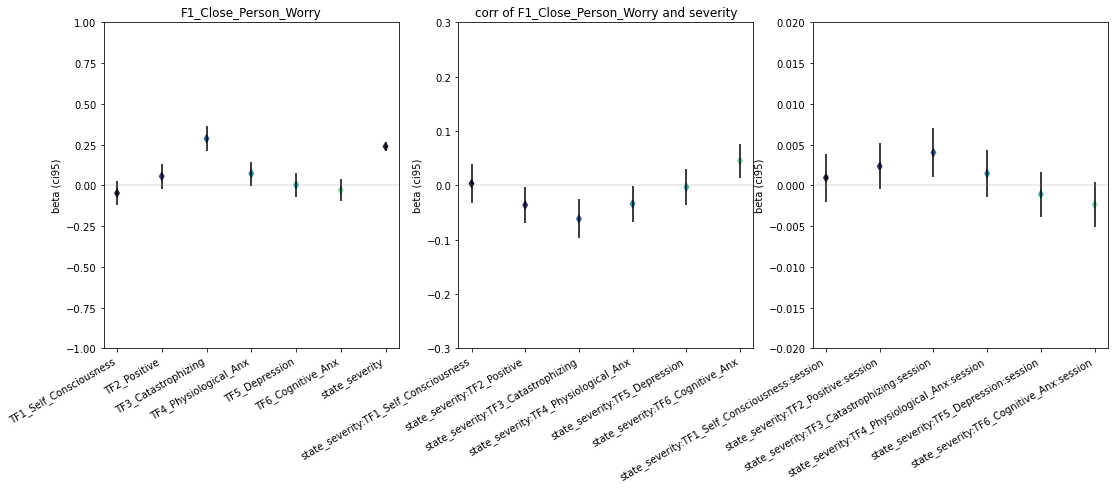

In [4]:
ylims = [[-1,1], [-0.3, 0.3], [-0.02, 0.02]]
model_constant = "severity_slopes_and_session_ND"
folder = "traits_predicting_severity_correlations"

f = "F1_Close_Person_Worry"
f_idx = 1
models = json.load(open(os.path.join(root_dir, "covid-fear", "model_dbs", "model_database.json"), "r")) 
mod = models["F"+str(f_idx)+"_"+model_constant+"_4_3000"]
mod["current_sys_location"] = os.path.join(root_dir, mod["location"])
mod, res, m = mm.estimate_lmm(mod, [], override=0)
display.display(az.summary(res).head(15))
# PLOT
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))
for gr_idx, beta_group in enumerate([trait_factor_names+['state_severity'],
                                    ['state_severity:'+i for i in trait_factor_names],
                                    ['state_severity:'+i+":session" for i in trait_factor_names]]):
    tdf = pd.DataFrame()
    for tf in beta_group:
        d = res.posterior[tf].stack(draws=("chain", "draw"))
        dt = pd.DataFrame(d, columns=["sample"])
        dt.loc[:,"trait_factor"] = tf
        tdf = pd.concat([tdf, dt])
    tdf
    axs[gr_idx] = sns.pointplot(x="trait_factor", y= "sample",
                  data=tdf, dodge=.532, join=False, palette=sns.color_palette("mako",6),
                  markers="d", scale=.75, ci=None, ax =axs[gr_idx]);
    bounds = tdf.groupby("trait_factor")['sample'].quantile((0.025,0.975)).unstack().reset_index().sort_values(by="trait_factor")
    axs[gr_idx].vlines(bounds.trait_factor, bounds.iloc[:,1], bounds.iloc[:,2], colors='black')
    axs[gr_idx].axhline(0, alpha=0.2, color='gray')
    if gr_idx == 0:
        axs[gr_idx].set_title(f)
    elif gr_idx == 1:
        axs[gr_idx].set_title("corr of "+f+" and severity")
    axs[gr_idx].set_ylabel("beta (ci95)")
    axs[gr_idx].set_xlabel("")
    axs[gr_idx].set_xticklabels(beta_group, rotation = 30, ha="right")
    axs[gr_idx].set_ylim(ylims[gr_idx])

### Economic worry (i.e. )

1. State severity overall increses economic worry
2. Catastrophizing increases overall economic worry
3. State severity interacts negatively with catastrophizing - people who are higher in cat tend to be less impacted  **investigate further (check for ceiling effect)**
4. This relationship between severity and cat changes over time - **investigate further**
5. Economic worry is increased by interactio nof state severity and cognitive anxiety 

Model F3_severity_slopes_and_session_ND_4_3000 already exist, loading it.


mean     sd  hdi_3%  hdi_97%  \
Intercept                              1.147  0.029   1.094    1.202   
state_severity                         0.206  0.011   0.184    0.226   
TF1_Self_Consciousness                 0.006  0.035  -0.059    0.072   
TF2_Positive                           0.038  0.036  -0.028    0.104   
TF3_Catastrophizing                    0.168  0.037   0.098    0.235   
TF4_Physiological_Anx                 -0.023  0.035  -0.087    0.042   
TF5_Depression                         0.037  0.035  -0.028    0.103   
TF6_Cognitive_Anx                     -0.033  0.033  -0.098    0.026   
state_severity:TF1_Self_Consciousness -0.011  0.014  -0.037    0.015   
state_severity:TF2_Positive            0.000  0.013  -0.024    0.025   
state_severity:TF3_Catastrophizing    -0.055  0.014  -0.080   -0.028   
state_severity:TF4_Physiological_Anx   0.023  0.013  -0.001    0.049   
state_severity:TF5_Depression          0.019  0.013  -0.005    0.044   
state_severity:TF6_Cognitive_Anx       0.050  0.012   0.027    0.073   
session                               -0.009  0.001  -0.011   -0.006   

                                       mcse_mean  mcse_sd  ess_bulk  ess_tail  \
Intercept                                  0.001    0.001    1642.0    3583.0   
state_severity                             0.000    0.000    8300.0    8885.0   
TF1_Self_Consciousness                     0.001    0.001    2018.0    3590.0   
TF2_Positive                               0.001    0.001    1830.0    3208.0   
TF3_Catastrophizing                        0.001    0.001    1887.0    4013.0   
TF4_Physiological_Anx                      0.001    0.001    1861.0    3679.0   
TF5_Depression                             0.001    0.001    2146.0    3665.0   
TF6_Cognitive_Anx                          0.001    0.001    1891.0    3525.0   
state_severity:TF1_Self_Consciousness      0.000    0.000    6851.0    8392.0   
state_severity:TF2_Positive                0.000    0.000    7135.0    9036.0   
state_severity:TF3_Catastrophizing         0.000    0.000    7735.0    9172.0   
state_severity:TF4_Physiological_Anx       0.000    0.000    8152.0    8555.0   
state_severity:TF5_Depression              0.000    0.000    7897.0    9253.0   
state_severity:TF6_Cognitive_Anx           0.000    0.000    8598.0    9091.0   
session                                    0.000    0.000    5751.0    8233.0   

                                       r_hat  
Intercept                                1.0  
state_severity                           1.0  
TF1_Self_Consciousness                   1.0  
TF2_Positive                             1.0  
TF3_Catastrophizing                      1.0  
TF4_Physiological_Anx                    1.0  
TF5_Depression                           1.0  
TF6_Cognitive_Anx                        1.0  
state_severity:TF1_Self_Consciousness    1.0  
state_severity:TF2_Positive              1.0  
state_severity:TF3_Catastrophizing       1.0  
state_severity:TF4_Physiological_Anx     1.0  
state_severity:TF5_Depression            1.0  
state_severity:TF6_Cognitive_Anx         1.0  
session                                  1.0

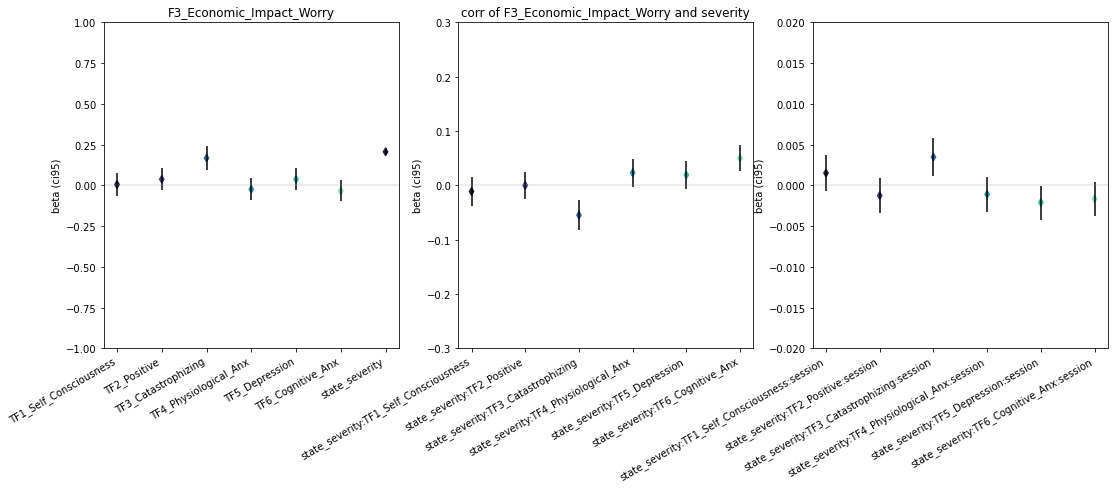

In [5]:
ylims = [[-1,1], [-0.3, 0.3], [-0.02, 0.02]]
model_constant = "severity_slopes_and_session_ND"
folder = "traits_predicting_severity_correlations"

f = "F3_Economic_Impact_Worry"
f_idx = 3
models = json.load(open(os.path.join(root_dir, "covid-fear", "model_dbs", "model_database.json"), "r")) 
mod = models["F"+str(f_idx)+"_"+model_constant+"_4_3000"]
mod["current_sys_location"] = os.path.join(root_dir, mod["location"])
mod, res, m = mm.estimate_lmm(mod, [], override=0)
display.display(az.summary(res).head(15))
# PLOT
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))
for gr_idx, beta_group in enumerate([trait_factor_names+['state_severity'],
                                    ['state_severity:'+i for i in trait_factor_names],
                                    ['state_severity:'+i+":session" for i in trait_factor_names]]):
    tdf = pd.DataFrame()
    for tf in beta_group:
        d = res.posterior[tf].stack(draws=("chain", "draw"))
        dt = pd.DataFrame(d, columns=["sample"])
        dt.loc[:,"trait_factor"] = tf
        tdf = pd.concat([tdf, dt])
    tdf
    axs[gr_idx] = sns.pointplot(x="trait_factor", y= "sample",
                  data=tdf, dodge=.532, join=False, palette=sns.color_palette("mako",6),
                  markers="d", scale=.75, ci=None, ax =axs[gr_idx]);
    bounds = tdf.groupby("trait_factor")['sample'].quantile((0.025,0.975)).unstack().reset_index().sort_values(by="trait_factor")
    axs[gr_idx].vlines(bounds.trait_factor, bounds.iloc[:,1], bounds.iloc[:,2], colors='black')
    axs[gr_idx].axhline(0, alpha=0.2, color='gray')
    if gr_idx == 0:
        axs[gr_idx].set_title(f)
    elif gr_idx == 1:
        axs[gr_idx].set_title("corr of "+f+" and severity")
    axs[gr_idx].set_ylabel("beta (ci95)")
    axs[gr_idx].set_xlabel("")
    axs[gr_idx].set_xticklabels(beta_group, rotation = 30, ha="right")
    axs[gr_idx].set_ylim(ylims[gr_idx])


### Anxiety/Avoidance
What predicts levels of anxiety/avoidance

1. State severity increases anxiety/avoidence in general
2. Catastrohpizing (future-oriented) trait generally positively predicts anx/avoid
3. Depression (TF5) negatively interacts with state severity - objective increase in severity has less impact in depressed individuals

0             q7_anx_another_beh
1         q7_anx_eating_food_out
2           q7_anx_public_transp
3      q7_anx_stand_close_to_ppl
4           q7_anx_touching_surf
5               q7_anx_visit_doc
6               q7_beh_avoid_ppl
7     q7_beh_avoid_public_places
8                               
9                               
10                              
11                              
12                              
Name: F2_Anxiety_Avoidance, dtype: object

Model F2_severity_slopes_and_session_ND_4_3000 already exist, loading it.


mean     sd  hdi_3%  hdi_97%  \
Intercept                              3.920  0.073   3.775    4.051   
state_severity                         0.288  0.023   0.245    0.333   
TF1_Self_Consciousness                -0.150  0.089  -0.314    0.021   
TF2_Positive                           0.229  0.089   0.064    0.397   
TF3_Catastrophizing                    0.502  0.094   0.326    0.679   
TF4_Physiological_Anx                 -0.023  0.087  -0.188    0.137   
TF5_Depression                         0.006  0.089  -0.164    0.168   
TF6_Cognitive_Anx                      0.003  0.081  -0.152    0.152   
state_severity:TF1_Self_Consciousness  0.020  0.030  -0.040    0.074   
state_severity:TF2_Positive           -0.048  0.028  -0.100    0.006   
state_severity:TF3_Catastrophizing    -0.016  0.030  -0.072    0.042   
state_severity:TF4_Physiological_Anx   0.014  0.029  -0.039    0.070   
state_severity:TF5_Depression         -0.062  0.029  -0.115   -0.008   
state_severity:TF6_Cognitive_Anx       0.045  0.027  -0.004    0.095   
session                               -0.033  0.004  -0.040   -0.026   

                                       mcse_mean  mcse_sd  ess_bulk  ess_tail  \
Intercept                                  0.002    0.002    1146.0    2095.0   
state_severity                             0.000    0.000    6147.0    8424.0   
TF1_Self_Consciousness                     0.003    0.002    1186.0    2726.0   
TF2_Positive                               0.002    0.002    1326.0    2580.0   
TF3_Catastrophizing                        0.003    0.002    1111.0    2526.0   
TF4_Physiological_Anx                      0.003    0.002     893.0    2170.0   
TF5_Depression                             0.003    0.002    1218.0    2372.0   
TF6_Cognitive_Anx                          0.002    0.002    1290.0    2391.0   
state_severity:TF1_Self_Consciousness      0.000    0.000    5208.0    8196.0   
state_severity:TF2_Positive                0.000    0.000    5384.0    7808.0   
state_severity:TF3_Catastrophizing         0.000    0.000    5502.0    7615.0   
state_severity:TF4_Physiological_Anx       0.000    0.000    5555.0    8314.0   
state_severity:TF5_Depression              0.000    0.000    5787.0    8075.0   
state_severity:TF6_Cognitive_Anx           0.000    0.000    6235.0    8375.0   
session                                    0.000    0.000    2330.0    4376.0   

                                       r_hat  
Intercept                                1.0  
state_severity                           1.0  
TF1_Self_Consciousness                   1.0  
TF2_Positive                             1.0  
TF3_Catastrophizing                      1.0  
TF4_Physiological_Anx                    1.0  
TF5_Depression                           1.0  
TF6_Cognitive_Anx                        1.0  
state_severity:TF1_Self_Consciousness    1.0  
state_severity:TF2_Positive              1.0  
state_severity:TF3_Catastrophizing       1.0  
state_severity:TF4_Physiological_Anx     1.0  
state_severity:TF5_Depression            1.0  
state_severity:TF6_Cognitive_Anx         1.0  
session                                  1.0

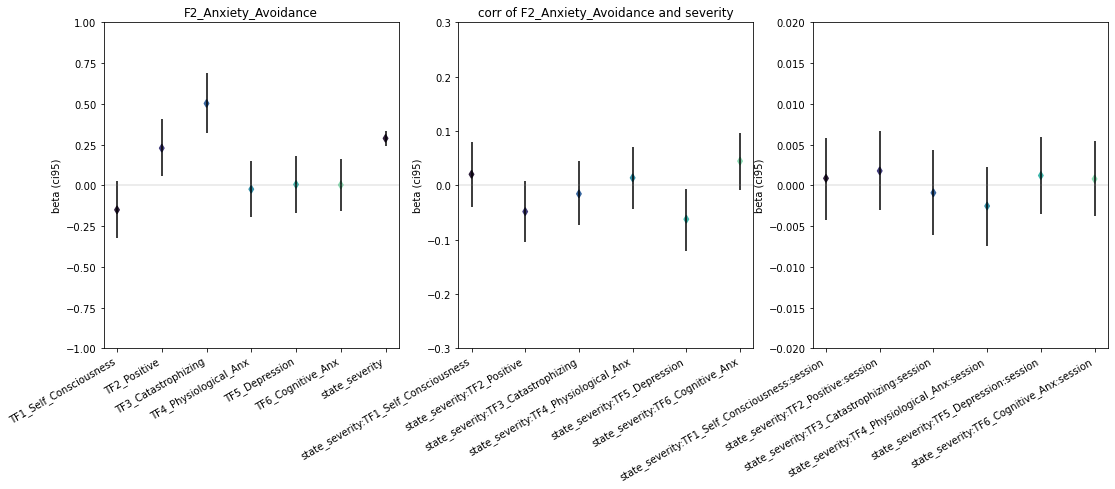

In [6]:
ylims = [[-1,1], [-0.3, 0.3], [-0.02, 0.02]]
model_constant = "severity_slopes_and_session_ND"
folder = "traits_predicting_severity_correlations"

f = "F2_Anxiety_Avoidance"
f_idx = 2
models = json.load(open(os.path.join(root_dir, "covid-fear", "model_dbs", "model_database.json"), "r")) 
mod = models["F"+str(f_idx)+"_"+model_constant+"_4_3000"]
mod["current_sys_location"] = os.path.join(root_dir, mod["location"])
mod, res, m = mm.estimate_lmm(mod, [], override=0)
display.display(az.summary(res).head(15))
# PLOT
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))
for gr_idx, beta_group in enumerate([trait_factor_names+['state_severity'],
                                    ['state_severity:'+i for i in trait_factor_names],
                                    ['state_severity:'+i+":session" for i in trait_factor_names]]):
    tdf = pd.DataFrame()
    for tf in beta_group:
        d = res.posterior[tf].stack(draws=("chain", "draw"))
        dt = pd.DataFrame(d, columns=["sample"])
        dt.loc[:,"trait_factor"] = tf
        tdf = pd.concat([tdf, dt])
    tdf
    axs[gr_idx] = sns.pointplot(x="trait_factor", y= "sample",
                  data=tdf, dodge=.532, join=False, palette=sns.color_palette("mako",6),
                  markers="d", scale=.75, ci=None, ax =axs[gr_idx]);
    bounds = tdf.groupby("trait_factor")['sample'].quantile((0.025,0.975)).unstack().reset_index().sort_values(by="trait_factor")
    axs[gr_idx].vlines(bounds.trait_factor, bounds.iloc[:,1], bounds.iloc[:,2], colors='black')
    axs[gr_idx].axhline(0, alpha=0.2, color='gray')
    if gr_idx == 0:
        axs[gr_idx].set_title(f)
    elif gr_idx == 1:
        axs[gr_idx].set_title("corr of "+f+" and severity")
    axs[gr_idx].set_ylabel("beta (ci95)")
    axs[gr_idx].set_xlabel("")
    axs[gr_idx].set_xticklabels(beta_group, rotation = 30, ha="right")
    axs[gr_idx].set_ylim(ylims[gr_idx])

### Probability estimates (estimated probability of aversive events)
1. state severity increases probability estimates
2. Catastrophising increases estimated probability of aversive events
3. Physiological anxiety increases estimated probability of aversive events
4. Cognitive anxiety decreases estimated probability of aversive events
5. "Positive" (discontent?) decreases estimated probability of aversive events
6. Objectve seveity interacts with physiological anx to reduce probability estimates (**investigate further (check for ceiling effect)**)

Model F4_severity_slopes_and_session_ND_4_3000 already exist, loading it.


mean     sd  hdi_3%  hdi_97%  \
Intercept                              1.118  0.037   1.049    1.186   
state_severity                         0.225  0.013   0.201    0.249   
TF1_Self_Consciousness                 0.025  0.046  -0.062    0.108   
TF2_Positive                          -0.111  0.045  -0.196   -0.029   
TF3_Catastrophizing                    0.152  0.049   0.061    0.243   
TF4_Physiological_Anx                  0.098  0.044   0.014    0.180   
TF5_Depression                         0.037  0.044  -0.044    0.121   
TF6_Cognitive_Anx                     -0.109  0.042  -0.189   -0.031   
state_severity:TF1_Self_Consciousness -0.005  0.017  -0.036    0.026   
state_severity:TF2_Positive           -0.000  0.015  -0.030    0.027   
state_severity:TF3_Catastrophizing    -0.010  0.016  -0.041    0.019   
state_severity:TF4_Physiological_Anx  -0.027  0.015  -0.057    0.001   
state_severity:TF5_Depression         -0.005  0.015  -0.034    0.023   
state_severity:TF6_Cognitive_Anx       0.024  0.014  -0.003    0.051   
session                               -0.008  0.002  -0.011   -0.005   

                                       mcse_mean  mcse_sd  ess_bulk  ess_tail  \
Intercept                                  0.001    0.001    1344.0    2777.0   
state_severity                             0.000    0.000    7084.0    8648.0   
TF1_Self_Consciousness                     0.001    0.001    1541.0    2759.0   
TF2_Positive                               0.001    0.001    1578.0    3151.0   
TF3_Catastrophizing                        0.001    0.001    1406.0    2670.0   
TF4_Physiological_Anx                      0.001    0.001    1572.0    2977.0   
TF5_Depression                             0.001    0.001    1728.0    3329.0   
TF6_Cognitive_Anx                          0.001    0.001    1560.0    3172.0   
state_severity:TF1_Self_Consciousness      0.000    0.000    5819.0    7912.0   
state_severity:TF2_Positive                0.000    0.000    6078.0    7922.0   
state_severity:TF3_Catastrophizing         0.000    0.000    6564.0    8923.0   
state_severity:TF4_Physiological_Anx       0.000    0.000    5639.0    7332.0   
state_severity:TF5_Depression              0.000    0.000    6318.0    8470.0   
state_severity:TF6_Cognitive_Anx           0.000    0.000    7498.0    8807.0   
session                                    0.000    0.000    3510.0    6593.0   

                                       r_hat  
Intercept                                1.0  
state_severity                           1.0  
TF1_Self_Consciousness                   1.0  
TF2_Positive                             1.0  
TF3_Catastrophizing                      1.0  
TF4_Physiological_Anx                    1.0  
TF5_Depression                           1.0  
TF6_Cognitive_Anx                        1.0  
state_severity:TF1_Self_Consciousness    1.0  
state_severity:TF2_Positive              1.0  
state_severity:TF3_Catastrophizing       1.0  
state_severity:TF4_Physiological_Anx     1.0  
state_severity:TF5_Depression            1.0  
state_severity:TF6_Cognitive_Anx         1.0  
session                                  1.0

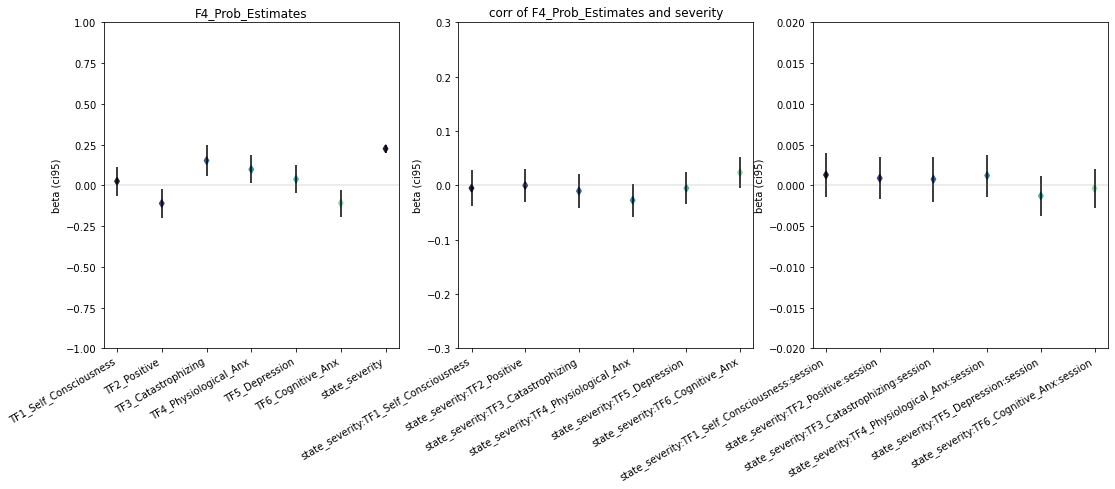

In [7]:
ylims = [[-1,1], [-0.3, 0.3], [-0.02, 0.02]]
model_constant = "severity_slopes_and_session_ND"
folder = "traits_predicting_severity_correlations"

f = "F4_Prob_Estimates"
f_idx = 4
models = json.load(open(os.path.join(root_dir, "covid-fear", "model_dbs", "model_database.json"), "r")) 
mod = models["F"+str(f_idx)+"_"+model_constant+"_4_3000"]
mod["current_sys_location"] = os.path.join(root_dir, mod["location"])
mod, res, m = mm.estimate_lmm(mod, [], override=0)
display.display(az.summary(res).head(15))
# PLOT
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))
for gr_idx, beta_group in enumerate([trait_factor_names+['state_severity'],
                                    ['state_severity:'+i for i in trait_factor_names],
                                    ['state_severity:'+i+":session" for i in trait_factor_names]]):
    tdf = pd.DataFrame()
    for tf in beta_group:
        d = res.posterior[tf].stack(draws=("chain", "draw"))
        dt = pd.DataFrame(d, columns=["sample"])
        dt.loc[:,"trait_factor"] = tf
        tdf = pd.concat([tdf, dt])
    tdf
    axs[gr_idx] = sns.pointplot(x="trait_factor", y= "sample",
                  data=tdf, dodge=.532, join=False, palette=sns.color_palette("mako",6),
                  markers="d", scale=.75, ci=None, ax =axs[gr_idx]);
    bounds = tdf.groupby("trait_factor")['sample'].quantile((0.025,0.975)).unstack().reset_index().sort_values(by="trait_factor")
    axs[gr_idx].vlines(bounds.trait_factor, bounds.iloc[:,1], bounds.iloc[:,2], colors='black')
    axs[gr_idx].axhline(0, alpha=0.2, color='gray')
    if gr_idx == 0:
        axs[gr_idx].set_title(f)
    elif gr_idx == 1:
        axs[gr_idx].set_title("corr of "+f+" and severity")
    axs[gr_idx].set_ylabel("beta (ci95)")
    axs[gr_idx].set_xlabel("")
    axs[gr_idx].set_xticklabels(beta_group, rotation = 30, ha="right")
    axs[gr_idx].set_ylim(ylims[gr_idx])

### Covid-related worry 
1. state severity increases covid-worry
2. Catastrophising increases covid-worry
3. "Discontent" increases covid-worry
4. Cognitive anxiety *decreases* covid worry ovrall but state severtiy increases it

Model F5_severity_slopes_and_session_ND_4_3000 already exist, loading it.


mean     sd  hdi_3%  hdi_97%  \
Intercept                              2.225  0.054   2.128    2.328   
state_severity                         0.299  0.019   0.264    0.334   
TF1_Self_Consciousness                -0.152  0.065  -0.279   -0.035   
TF2_Positive                           0.270  0.067   0.141    0.393   
TF3_Catastrophizing                    0.559  0.070   0.423    0.688   
TF4_Physiological_Anx                  0.074  0.065  -0.049    0.197   
TF5_Depression                         0.003  0.063  -0.119    0.120   
TF6_Cognitive_Anx                     -0.139  0.060  -0.254   -0.028   
state_severity:TF1_Self_Consciousness -0.011  0.023  -0.054    0.033   
state_severity:TF2_Positive            0.039  0.022  -0.002    0.080   
state_severity:TF3_Catastrophizing    -0.039  0.023  -0.083    0.005   
state_severity:TF4_Physiological_Anx  -0.037  0.022  -0.078    0.005   
state_severity:TF5_Depression         -0.023  0.022  -0.064    0.017   
state_severity:TF6_Cognitive_Anx       0.048  0.021   0.010    0.088   
session                               -0.016  0.002  -0.020   -0.011   

                                       mcse_mean  mcse_sd  ess_bulk  ess_tail  \
Intercept                                  0.001    0.001    1312.0    2695.0   
state_severity                             0.000    0.000    6973.0    8213.0   
TF1_Self_Consciousness                     0.002    0.001    1659.0    3498.0   
TF2_Positive                               0.002    0.001    1438.0    3131.0   
TF3_Catastrophizing                        0.002    0.001    1364.0    2684.0   
TF4_Physiological_Anx                      0.002    0.001    1286.0    2486.0   
TF5_Depression                             0.002    0.001    1664.0    3276.0   
TF6_Cognitive_Anx                          0.002    0.001    1407.0    2981.0   
state_severity:TF1_Self_Consciousness      0.000    0.000    6972.0    9141.0   
state_severity:TF2_Positive                0.000    0.000    7252.0    8900.0   
state_severity:TF3_Catastrophizing         0.000    0.000    6947.0    8652.0   
state_severity:TF4_Physiological_Anx       0.000    0.000    6715.0    8379.0   
state_severity:TF5_Depression              0.000    0.000    7535.0    9210.0   
state_severity:TF6_Cognitive_Anx           0.000    0.000    7718.0    9070.0   
session                                    0.000    0.000    4656.0    7357.0   

                                       r_hat  
Intercept                                1.0  
state_severity                           1.0  
TF1_Self_Consciousness                   1.0  
TF2_Positive                             1.0  
TF3_Catastrophizing                      1.0  
TF4_Physiological_Anx                    1.0  
TF5_Depression                           1.0  
TF6_Cognitive_Anx                        1.0  
state_severity:TF1_Self_Consciousness    1.0  
state_severity:TF2_Positive              1.0  
state_severity:TF3_Catastrophizing       1.0  
state_severity:TF4_Physiological_Anx     1.0  
state_severity:TF5_Depression            1.0  
state_severity:TF6_Cognitive_Anx         1.0  
session                                  1.0

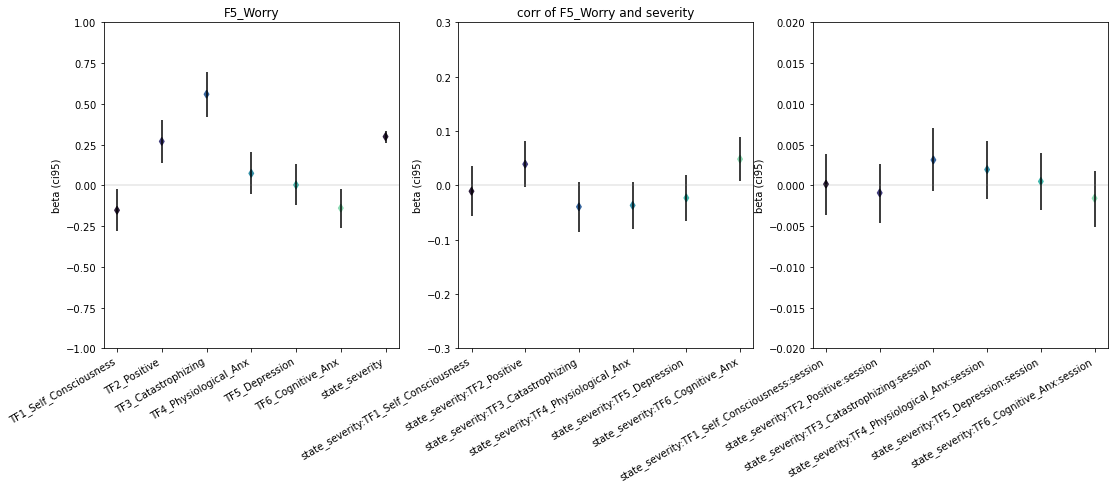

In [8]:
ylims = [[-1,1], [-0.3, 0.3], [-0.02, 0.02]]
model_constant = "severity_slopes_and_session_ND"
folder = "traits_predicting_severity_correlations"

f = "F5_Worry"
f_idx = 5
models = json.load(open(os.path.join(root_dir, "covid-fear", "model_dbs", "model_database.json"), "r")) 
mod = models["F"+str(f_idx)+"_"+model_constant+"_4_3000"]
mod["current_sys_location"] = os.path.join(root_dir, mod["location"])
mod, res, m = mm.estimate_lmm(mod, [], override=0)
display.display(az.summary(res).head(15))
# PLOT
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))
for gr_idx, beta_group in enumerate([trait_factor_names+['state_severity'],
                                    ['state_severity:'+i for i in trait_factor_names],
                                    ['state_severity:'+i+":session" for i in trait_factor_names]]):
    tdf = pd.DataFrame()
    for tf in beta_group:
        d = res.posterior[tf].stack(draws=("chain", "draw"))
        dt = pd.DataFrame(d, columns=["sample"])
        dt.loc[:,"trait_factor"] = tf
        tdf = pd.concat([tdf, dt])
    tdf
    axs[gr_idx] = sns.pointplot(x="trait_factor", y= "sample",
                  data=tdf, dodge=.532, join=False, palette=sns.color_palette("mako",6),
                  markers="d", scale=.75, ci=None, ax =axs[gr_idx]);
    bounds = tdf.groupby("trait_factor")['sample'].quantile((0.025,0.975)).unstack().reset_index().sort_values(by="trait_factor")
    axs[gr_idx].vlines(bounds.trait_factor, bounds.iloc[:,1], bounds.iloc[:,2], colors='black')
    axs[gr_idx].axhline(0, alpha=0.2, color='gray')
    if gr_idx == 0:
        axs[gr_idx].set_title(f)
    elif gr_idx == 1:
        axs[gr_idx].set_title("corr of "+f+" and severity")
    axs[gr_idx].set_ylabel("beta (ci95)")
    axs[gr_idx].set_xlabel("")
    axs[gr_idx].set_xticklabels(beta_group, rotation = 30, ha="right")
    axs[gr_idx].set_ylim(ylims[gr_idx])

### Skepticism
1. State severity is *negatively associated* with state skepticism
2. Catastrophizing is negatively associated with skepticism

Model F6_severity_slopes_and_session_ND_4_3000 already exist, loading it.


mean     sd  hdi_3%  hdi_97%  \
Intercept                             -0.023  0.029  -0.079    0.031   
state_severity                        -0.040  0.010  -0.058   -0.022   
TF1_Self_Consciousness                 0.024  0.036  -0.044    0.093   
TF2_Positive                          -0.021  0.036  -0.091    0.045   
TF3_Catastrophizing                   -0.145  0.037  -0.216   -0.077   
TF4_Physiological_Anx                 -0.006  0.036  -0.072    0.062   
TF5_Depression                         0.053  0.035  -0.015    0.118   
TF6_Cognitive_Anx                     -0.003  0.034  -0.066    0.060   
state_severity:TF1_Self_Consciousness -0.007  0.012  -0.028    0.018   
state_severity:TF2_Positive           -0.001  0.011  -0.023    0.020   
state_severity:TF3_Catastrophizing     0.004  0.012  -0.019    0.027   
state_severity:TF4_Physiological_Anx  -0.007  0.012  -0.029    0.014   
state_severity:TF5_Depression          0.018  0.011  -0.003    0.040   
state_severity:TF6_Cognitive_Anx       0.008  0.011  -0.012    0.029   
session                               -0.004  0.002  -0.007   -0.001   

                                       mcse_mean  mcse_sd  ess_bulk  ess_tail  \
Intercept                                  0.001    0.001    1014.0    1913.0   
state_severity                             0.000    0.000    5402.0    7733.0   
TF1_Self_Consciousness                     0.001    0.001    1197.0    2042.0   
TF2_Positive                               0.001    0.001    1019.0    2247.0   
TF3_Catastrophizing                        0.001    0.001    1117.0    2188.0   
TF4_Physiological_Anx                      0.001    0.001    1150.0    2322.0   
TF5_Depression                             0.001    0.001    1201.0    2861.0   
TF6_Cognitive_Anx                          0.001    0.001    1090.0    2423.0   
state_severity:TF1_Self_Consciousness      0.000    0.000    4800.0    7258.0   
state_severity:TF2_Positive                0.000    0.000    4660.0    6402.0   
state_severity:TF3_Catastrophizing         0.000    0.000    4023.0    6272.0   
state_severity:TF4_Physiological_Anx       0.000    0.000    5273.0    8055.0   
state_severity:TF5_Depression              0.000    0.000    5125.0    7591.0   
state_severity:TF6_Cognitive_Anx           0.000    0.000    5896.0    8461.0   
session                                    0.000    0.000    2108.0    3899.0   

                                       r_hat  
Intercept                                1.0  
state_severity                           1.0  
TF1_Self_Consciousness                   1.0  
TF2_Positive                             1.0  
TF3_Catastrophizing                      1.0  
TF4_Physiological_Anx                    1.0  
TF5_Depression                           1.0  
TF6_Cognitive_Anx                        1.0  
state_severity:TF1_Self_Consciousness    1.0  
state_severity:TF2_Positive              1.0  
state_severity:TF3_Catastrophizing       1.0  
state_severity:TF4_Physiological_Anx     1.0  
state_severity:TF5_Depression            1.0  
state_severity:TF6_Cognitive_Anx         1.0  
session                                  1.0

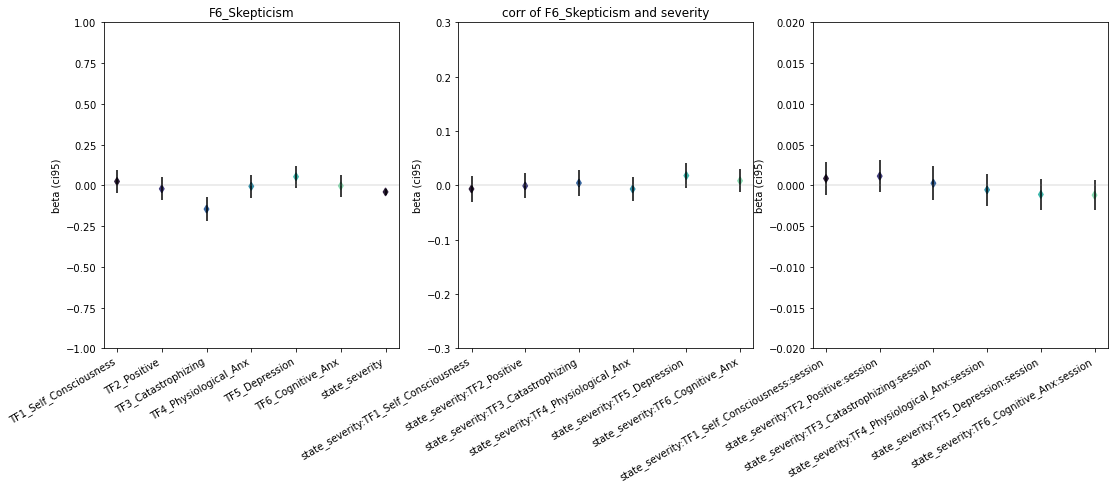

In [9]:
ylims = [[-1,1], [-0.3, 0.3], [-0.02, 0.02]]
model_constant = "severity_slopes_and_session_ND"
folder = "traits_predicting_severity_correlations"

f = "F6_Skepticism"
f_idx = 6
models = json.load(open(os.path.join(root_dir, "covid-fear", "model_dbs", "model_database.json"), "r")) 
mod = models["F"+str(f_idx)+"_"+model_constant+"_4_3000"]
mod["current_sys_location"] = os.path.join(root_dir, mod["location"])
mod, res, m = mm.estimate_lmm(mod, [], override=0)
display.display(az.summary(res).head(15))
# PLOT
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))
for gr_idx, beta_group in enumerate([trait_factor_names+['state_severity'],
                                    ['state_severity:'+i for i in trait_factor_names],
                                    ['state_severity:'+i+":session" for i in trait_factor_names]]):
    tdf = pd.DataFrame()
    for tf in beta_group:
        d = res.posterior[tf].stack(draws=("chain", "draw"))
        dt = pd.DataFrame(d, columns=["sample"])
        dt.loc[:,"trait_factor"] = tf
        tdf = pd.concat([tdf, dt])
    tdf
    axs[gr_idx] = sns.pointplot(x="trait_factor", y= "sample",
                  data=tdf, dodge=.532, join=False, palette=sns.color_palette("mako",6),
                  markers="d", scale=.75, ci=None, ax =axs[gr_idx]);
    bounds = tdf.groupby("trait_factor")['sample'].quantile((0.025,0.975)).unstack().reset_index().sort_values(by="trait_factor")
    axs[gr_idx].vlines(bounds.trait_factor, bounds.iloc[:,1], bounds.iloc[:,2], colors='black')
    axs[gr_idx].axhline(0, alpha=0.2, color='gray')
    if gr_idx == 0:
        axs[gr_idx].set_title(f)
    elif gr_idx == 1:
        axs[gr_idx].set_title("corr of "+f+" and severity")
    axs[gr_idx].set_ylabel("beta (ci95)")
    axs[gr_idx].set_xlabel("")
    axs[gr_idx].set_xticklabels(beta_group, rotation = 30, ha="right")
    axs[gr_idx].set_ylim(ylims[gr_idx])

### Summary

**Worry about close person (also a bit of media frequency)**

1. State severity overall increses worry about close person 
2. Catastrophizing and Physiological anxiety increase overall close person worry
3. State severity interacts negatively with catastrophizing - people who are higher in cat tend to be less impacted  **investigate further (check for ceiling effect)**
4. This relationship between severity and cat changes over time - **investigate further**
4. State severity interacts negatively with physiological anxiety - people who are higher in phys anx tend to be less impacted by severity  **investigate further (check for ceiling effect)**
5. State severity interacts negatively with discontent - people who are higher in discontent tend to be less impacted by severity  **investigate further (check for ceiling effect)**

**Economic worry**
1. State severity overall increses economic worry
2. Catastrophizing increases overall economic worry
3. State severity interacts negatively with catastrophizing - people who are higher in cat tend to be less impacted  **investigate further (check for ceiling effect)**
4. This relationship between severity and cat changes over time - **investigate further**
5. Economic worry is increased by interactio nof state severity and cognitive anxiety 

**Anxiety/Avoidance**
What predicts levels of anxiety/avoidance

1. State severity increases anxiety/avoidence in general
2. Catastrohpizing (future-oriented) trait generally positively predicts anx/avoid
3. Depression (TF5) negatively interacts with state severity - objective increase in severity has less impact in depressed individuals

**Probability estimates (estimated probability of aversive events)**
1. state severity increases probability estimates
2. Catastrophising increases estimated probability of aversive events
3. Physiological anxiety increases estimated probability of aversive events
4. Cognitive anxiety decreases estimated probability of aversive events
5. "Positive" (discontent?) decreases estimated probability of aversive events
6. Objectve seveity interacts with physiological anx to reduce probability estimates (**investigate further (check for ceiling effect)**)

**Covid-related worry** 
1. state severity increases covid-worry
2. Catastrophising increases covid-worry
3. "Discontent" increases covid-worry
4. Cognitive anxiety *decreases* covid worry ovrall but state severtiy increases it

**Skpeticism**
1. State severity is *negatively associated* with state skepticism
2. Catastrophizing is negatively associated with skepticism

### To do 
1. Check variance inflation in models. 
2. Check for ceiling effects 

Model F6_severity_slopes_and_session_ND_4_3000 already exist, loading it.


mean     sd  hdi_3%  hdi_97%  \
Intercept                             -0.023  0.029  -0.079    0.031   
state_severity                        -0.040  0.010  -0.058   -0.022   
TF1_Self_Consciousness                 0.024  0.036  -0.044    0.093   
TF2_Positive                          -0.021  0.036  -0.091    0.045   
TF3_Catastrophizing                   -0.145  0.037  -0.216   -0.077   
TF4_Physiological_Anx                 -0.006  0.036  -0.072    0.062   
TF5_Depression                         0.053  0.035  -0.015    0.118   
TF6_Cognitive_Anx                     -0.003  0.034  -0.066    0.060   
state_severity:TF1_Self_Consciousness -0.007  0.012  -0.028    0.018   
state_severity:TF2_Positive           -0.001  0.011  -0.023    0.020   
state_severity:TF3_Catastrophizing     0.004  0.012  -0.019    0.027   
state_severity:TF4_Physiological_Anx  -0.007  0.012  -0.029    0.014   
state_severity:TF5_Depression          0.018  0.011  -0.003    0.040   
state_severity:TF6_Cognitive_Anx       0.008  0.011  -0.012    0.029   
session                               -0.004  0.002  -0.007   -0.001   

                                       mcse_mean  mcse_sd  ess_bulk  ess_tail  \
Intercept                                  0.001    0.001    1014.0    1913.0   
state_severity                             0.000    0.000    5402.0    7733.0   
TF1_Self_Consciousness                     0.001    0.001    1197.0    2042.0   
TF2_Positive                               0.001    0.001    1019.0    2247.0   
TF3_Catastrophizing                        0.001    0.001    1117.0    2188.0   
TF4_Physiological_Anx                      0.001    0.001    1150.0    2322.0   
TF5_Depression                             0.001    0.001    1201.0    2861.0   
TF6_Cognitive_Anx                          0.001    0.001    1090.0    2423.0   
state_severity:TF1_Self_Consciousness      0.000    0.000    4800.0    7258.0   
state_severity:TF2_Positive                0.000    0.000    4660.0    6402.0   
state_severity:TF3_Catastrophizing         0.000    0.000    4023.0    6272.0   
state_severity:TF4_Physiological_Anx       0.000    0.000    5273.0    8055.0   
state_severity:TF5_Depression              0.000    0.000    5125.0    7591.0   
state_severity:TF6_Cognitive_Anx           0.000    0.000    5896.0    8461.0   
session                                    0.000    0.000    2108.0    3899.0   

                                       r_hat  
Intercept                                1.0  
state_severity                           1.0  
TF1_Self_Consciousness                   1.0  
TF2_Positive                             1.0  
TF3_Catastrophizing                      1.0  
TF4_Physiological_Anx                    1.0  
TF5_Depression                           1.0  
TF6_Cognitive_Anx                        1.0  
state_severity:TF1_Self_Consciousness    1.0  
state_severity:TF2_Positive              1.0  
state_severity:TF3_Catastrophizing       1.0  
state_severity:TF4_Physiological_Anx     1.0  
state_severity:TF5_Depression            1.0  
state_severity:TF6_Cognitive_Anx         1.0  
session                                  1.0

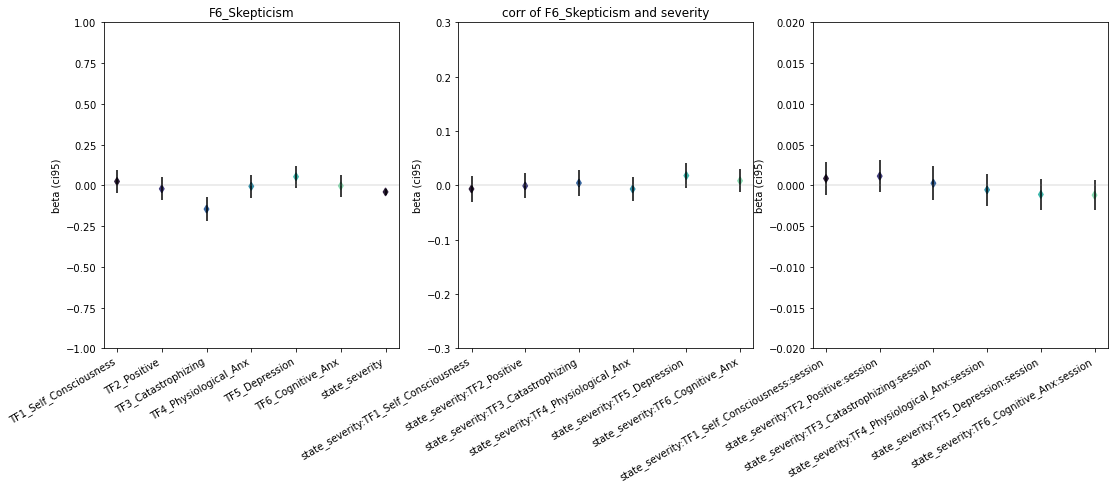

In [10]:
df = pd.read_csv(os.path.join(root_dir, "data", "full_dataset_only_complete.csv"))
df["session"] =  df["session"] + 1
dfl = df.loc[:,[f, "state_severity", "PROLIFICID", "session"]+trait_factor_names].dropna()

ylims = [[-1,1], [-0.3, 0.3], [-0.02, 0.02]]
model_constant = "severity_slopes_and_session_ND"
folder = "traits_predicting_severity_correlations"

f = "F6_Skepticism"
f_idx = 6
models = json.load(open(os.path.join(root_dir, "covid-fear", "model_dbs", "model_database.json"), "r")) 
mod = models["F"+str(f_idx)+"_"+model_constant+"_4_3000"]
mod["current_sys_location"] = os.path.join(root_dir, mod["location"])
mod, res, m = mm.estimate_lmm(mod, dfl, override=0)
display.display(az.summary(res).head(15))
# PLOT
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))
for gr_idx, beta_group in enumerate([trait_factor_names+['state_severity'],
                                    ['state_severity:'+i for i in trait_factor_names],
                                    ['state_severity:'+i+":session" for i in trait_factor_names]]):
    tdf = pd.DataFrame()
    for tf in beta_group:
        d = res.posterior[tf].stack(draws=("chain", "draw"))
        dt = pd.DataFrame(d, columns=["sample"])
        dt.loc[:,"trait_factor"] = tf
        tdf = pd.concat([tdf, dt])
    tdf
    axs[gr_idx] = sns.pointplot(x="trait_factor", y= "sample",
                  data=tdf, dodge=.532, join=False, palette=sns.color_palette("mako",6),
                  markers="d", scale=.75, ci=None, ax =axs[gr_idx]);
    bounds = tdf.groupby("trait_factor")['sample'].quantile((0.025,0.975)).unstack().reset_index().sort_values(by="trait_factor")
    axs[gr_idx].vlines(bounds.trait_factor, bounds.iloc[:,1], bounds.iloc[:,2], colors='black')
    axs[gr_idx].axhline(0, alpha=0.2, color='gray')
    if gr_idx == 0:
        axs[gr_idx].set_title(f)
    elif gr_idx == 1:
        axs[gr_idx].set_title("corr of "+f+" and severity")
    axs[gr_idx].set_ylabel("beta (ci95)")
    axs[gr_idx].set_xlabel("")
    axs[gr_idx].set_xticklabels(beta_group, rotation = 30, ha="right")
    axs[gr_idx].set_ylim(ylims[gr_idx])

In [11]:
eq = mod["lmm"]["eq"]
m = bmb.Model(eq, tdf, family="gaussian", link="identity")
m.build()
prior = m.prior_predictive(1000)

KeyError: 'state_severity'

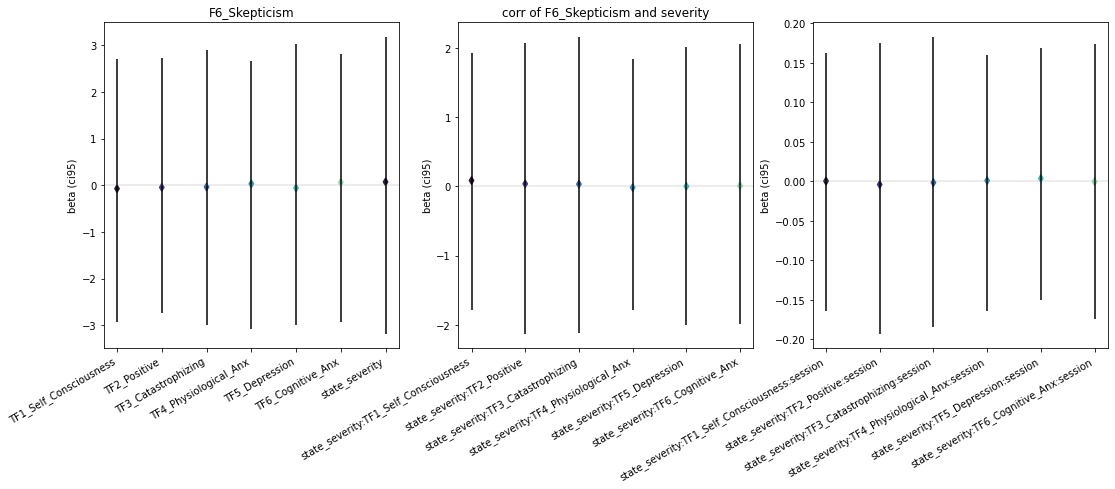

In [25]:
# plot prior
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))
for gr_idx, beta_group in enumerate([trait_factor_names+['state_severity'],
                                    ['state_severity:'+i for i in trait_factor_names],
                                    ['state_severity:'+i+":session" for i in trait_factor_names]]):
    tdf = pd.DataFrame()
    for tf in beta_group:
        d = prior.prior[tf].stack(draws=("chain", "draw"))
        dt = pd.DataFrame(d, columns=["sample"])
        dt.loc[:,"trait_factor"] = tf
        tdf = pd.concat([tdf, dt])
    tdf
    axs[gr_idx] = sns.pointplot(x="trait_factor", y= "sample",
                  data=tdf, dodge=.532, join=False, palette=sns.color_palette("mako",6),
                  markers="d", scale=.75, ci=None, ax =axs[gr_idx]);
    bounds = tdf.groupby("trait_factor")['sample'].quantile((0.025,0.975)).unstack().reset_index().sort_values(by="trait_factor")
    axs[gr_idx].vlines(bounds.trait_factor, bounds.iloc[:,1], bounds.iloc[:,2], colors='black')
    axs[gr_idx].axhline(0, alpha=0.2, color='gray')
    if gr_idx == 0:
        axs[gr_idx].set_title(f)
    elif gr_idx == 1:
        axs[gr_idx].set_title("corr of "+f+" and severity")
    axs[gr_idx].set_ylabel("beta (ci95)")
    axs[gr_idx].set_xlabel("")
    axs[gr_idx].set_xticklabels(beta_group, rotation = 30, ha="right")
    #axs[gr_idx].set_ylim(ylims[gr_idx])